## Biodiversity composition change loss due to land use change
We propose the estimation of biodiversity loss due to land use change which will consist in estimateing the regional species loss,displacement or reduction of species that would otherwise exist in the land if it wouldn't be used for production of a certain commodity as well as the relative abundance within the ecoregion due to land use change.

    Biodiversity loss due to land use change (PDF / year) =  = area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (1/ 0.0001) (conversion units) *  probability purchase area (unitless) 

Where:

- Area with tree cover loss and land use change (m2) would e the area of tree cover loss detected for different years using GFW/ sateligence data and where a land use change from either  forest to arable or forest to grassland has taken place. This area will be detected using Hansen data following the approach highlighted here.
- Taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2)
- The multiplication by 10000 gets hectares and the division by 0.0001 converts m2 to hectares
- Probability purchase area is the potential area where a certain commodity has been purchased from. The calculation of this probability purchase area would be done following the workflow highlighted here.

## Land use productivity

In order to track the land use expansion and land productivity, we propose the two formulas below:

    Land use (ha * year) = (Area fraction  * Volume (Tonnes))  / (Total Area fraction * yield (Tonnes / hectare)
    
Where:
- The land use area would be a purchased area for a certain commodity per a certain year. The calculation would be the same as the one described here.
- Area fraction would be the area used for a specific commodity in a h3 grid. This information would be obtained from EarthStat.
- Total Area Fraction would be the sum of all the area fraction from EarthStat in the supply shed. 
- Yield would be the tonnes produced in an hectare obtained from EarthStat.
- Volume would be the Total Volume purchased for a certain commodity by a specific year and location.



    Yield (Tonnes / ha * year) =  Volume (Tonnes) / Land use (ha * year)
    
    Yield (Tonnes / ha * year) = (Total Area fraction * yield (Tonnes / hectare)  /  Area fraction 

Where:

- Volume would be the Total Volume purchased for a certain commodity by a specific year and location.
- The land use area would be a purchased area for a certain commodity per a certain year. The calculation would be the same as the one described here.


## Table of Contents
- ### [1. Import libraries](#libraries)
- ### [2. Calculate biodiversity risk map](#risk_map)
    - #### [2.1. import taxa aggregated characterisation factors](#taxa_cf)
    - #### [2.2. Import ecoregions layer](#ecoregions)
    - #### [2.3. Join ecoregions layer with the taxa caracterization factors by ecoregion](#join)
    - #### [2.4. Generate raster for the taxa aggregated characterization factors by ecoregion.](#generate_rater) 
    - #### [2. 5. Generate the biodiversity risk map](#generate_risk)
- ### [3. Calculate biodiversity impact metric](#impact_metric)
- ### [4. Final notes](#finalNotes)

<a id='libraries'></a>
### 1. Import libraries

In [11]:
## import libraries
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
import rasterio.plot
from rasterstats import zonal_stats

<a id='risk_map'></a>
## 2. Calculate biodiversity risk map

Before estimating the biodiversity impact due to land use change in a specific supply area we will need to determine the risk of biodiversity loss due to land use change. For determine this risk we will be following the formula below, which will be commodity dependent:

    Biodiversity loss due to land use change (PDF / year) =  area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (1/ 0.0001) (conversion units)
    
where:

- area with tree cover loss and land use change (hectares) which will be obtained from the deforestation risk map. This deforestation risk will be commodity dependent. 
- taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) derived from the LCIA characterization factors
- division from 0.0001 to convert from m2 to hectares 

Note: Potentially Disappeared Species (PDS)

<a id='taxa_cf'></a>
### 2.1. import taxa aggregated characterisation factors

The characetrization factors have been obtained from the following link: https://www.lifecycleinitiative.org/applying-lca/lcia-cf/

This characterization factors have been also saved on the share drive. For the biodiversity risk map we will be using the Regional Potential Species Loss due to land use change at ecoregion level.


In [11]:
df = pd.read_excel(
    r"../../datasets/raw/biodiversity_indicators/Ch6 PSLregional v01.xlsx",
    sheet_name="Transformation_Ecoregion",
    header=[3],
)
df.head()

,eco_code,Median,lower 95%,upper 95%,Median.1,lower 95%.1,upper 95%.1,Median.2,lower 95%.2,upper 95%.2,Median.3,lower 95%.3,upper 95%.3,Median.4,lower 95%.4,upper 95%.4,Median.5,lower 95%.5,upper 95%.5
0,World average,2.880992e-12,-4.658128e-13,7.776529e-12,2.312977e-12,-1.304287e-12,8.469779e-12,1.875973e-12,-1.600759e-12,8.391349e-12,4.430366e-12,6.457714e-14,9.039383e-12,6.079169e-13,-9.405671e-13,4.497921e-12,1.478220e-12,-1.604768e-12,7.346928e-12
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,3.504606e-11,-1.673912e-11,1.546130e-10,2.438062e-11,-2.792929e-11,1.337088e-10,NaN,NaN,NaN,1.430631e-11,-7.042386e-13,8.071432e-11,3.027136e-11,-1.907786e-11,1.419584e-10
2,AA0102,2.664063e-11,-9.488066e-13,7.426592e-11,2.390119e-11,-3.142746e-12,7.106328e-11,1.220219e-11,-2.413976e-11,6.924044e-11,3.801648e-11,2.257569e-12,8.972848e-11,5.158636e-12,-2.444711e-12,3.797641e-11,1.854157e-11,-8.772367e-12,7.009282e-11
3,AA0103,4.682694e-11,-6.886077e-12,1.544679e-10,3.522323e-11,-1.902498e-11,1.463752e-10,1.899118e-11,-5.536463e-11,1.328678e-10,6.769960e-11,0.000000e+00,1.596704e-10,1.375353e-11,-9.773335e-13,7.622320e-11,2.925349e-11,-1.895998e-11,1.311491e-10
4,AA0104,1.622572e-11,-1.186395e-12,4.908715e-11,1.368277e-11,-4.649506e-12,4.801403e-11,7.269697e-12,-1.919075e-11,4.605131e-11,2.437949e-11,0.000000e+00,5.667906e-11,3.979111e-12,-3.025170e-13,2.479203e-11,1.168076e-11,-5.450018e-12,4.411466e-11


In [12]:
## select for the moment annual crops
pdf_annual_crops = df[["eco_code", "Median", "lower 95%", "upper 95%"]]
pdf_annual_crops.head()

,eco_code,Median,lower 95%,upper 95%
0,World average,2.880992e-12,-4.658128e-13,7.776529e-12
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10
2,AA0102,2.664063e-11,-9.488066e-13,7.426592e-11
3,AA0103,4.682694e-11,-6.886077e-12,1.544679e-10
4,AA0104,1.622572e-11,-1.186395e-12,4.908715e-11


<a id='ecoregions'></a>
### 2.2. Import ecoregions layer

In [17]:
## import the ecoregions data
ecoregions = gpd.read_file("../../datasets/raw/biodiversity_indicators/official/wwf_terr_ecos.shp")
ecoregions.head()

,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,...,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,eco_code,PER_area,PER_area_1,PER_area_2,geometry
0,1,29.802942,0.219,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.219475,0.002769,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.26972 29.32648, -112.28809 29.3..."
1,2,11.977824,0.193,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.193289,0.001111,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-112.19907 29.17528, -112.20740 29.1..."
2,3,77301.372760,111.954,Sinaloan dry forests,NT,2.0,28.0,60228.0,98.0,1.0,...,2.0,1.0,111.951414,6.879188,77362,NT0228,0.0,0.0,0.0,"POLYGON ((-109.11700 27.74142, -109.11228 27.7..."
3,4,215.489182,1.274,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,1.273654,0.019701,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.54179 27.38383, -110.54462 27.3..."
4,5,19.639089,0.363,Northern Mesoamerican Pacific mangroves,NT,14.0,4.0,61404.0,119.0,1.0,...,0.0,0.0,0.363068,0.001791,8174,NT1404,0.0,0.0,0.0,"POLYGON ((-110.52850 27.28641, -110.53336 27.2..."


<a id='join'></a>
### 2.3. Join ecoregions layer with the taxa caracterization factors by ecoregion

In [18]:
ecoregions_PDF = pd.merge(pdf_annual_crops, ecoregions, how="inner", on="eco_code")
ecoregions_PDF.head()

,eco_code,Median,lower 95%,upper 95%,OBJECTID,AREA,PERIMETER,ECO_NAME,REALM,BIOME,...,G200_NUM,G200_BIOME,G200_STAT,Shape_Leng,Shape_Area,area_km2,PER_area,PER_area_1,PER_area_2,geometry
0,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,10900,16.678311,0.198,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.198109,0.001356,2099,0.0,0.0,0.0,"POLYGON ((147.59106 -2.09207, 147.57886 -2.090..."
1,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11856,1874.284908,2.880,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,2.879881,0.152367,2099,0.0,0.0,0.0,"POLYGON ((146.81030 -1.96906, 146.81750 -1.964..."
2,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11865,12.722658,0.155,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.155184,0.001034,2099,0.0,0.0,0.0,"POLYGON ((147.39548 -1.99151, 147.41811 -2.001..."
3,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11932,12.841929,0.120,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.120138,0.001044,2099,0.0,0.0,0.0,"POLYGON ((147.27190 -2.54659, 147.28200 -2.541..."
4,AA0101,4.670750e-11,-5.492811e-12,1.676778e-10,11678,8.700576,0.134,Admiralty Islands lowland rain forests,AA,1.0,...,0.0,0.0,0.0,0.134267,0.000707,2099,0.0,0.0,0.0,"POLYGON ((144.20190 -1.40101, 144.19025 -1.399..."


In [19]:
ecoregions_PDF = ecoregions_PDF.set_geometry("geometry")

In [57]:
# export
ecoregions_PDF.to_file(
    "../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors.shp",
    driver="ESRI Shapefile",
)

<a id='generate_raster'></a>
### 2.4. Generate raster for the taxa aggregated characterization factors by ecoregion.

For doing the calculations at this point we want to rasterize the polygon into raster, using the same resolution as the other datasets used for the calculation of the biodiversity risk map. 

The resolution of the deforestation risk that we are going to use is 0.0002694944179760000078 (30m res) which will be produce a really heavy global dataset for working in local. In this case, I'm going to rasterize the polygon to the global resolution of the crops datasets which is 0.0833333333333286 (10km res) and we will ne to clip the data later for the area of interest and downsample that clip area to the highest resolution.

NOTE: This process described above would be done just in the prototype for producing a more managable dataset. 

In [58]:
!gdal_rasterize -l taxa_aggregated_characterization_factors -a Median -tr 0.0833333333333286 0.0833333333333286 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff '../../datasets/processed/taxa_aggregated_characterization_factors.shp' '../../datasets/processed/taxa_aggregated_characterization_factors_4326.tif'




0...10...20...30...40...50...60...70...80...90...100 - done.


In [23]:
!gdalinfo -stats -hist '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif
       ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif.aux.xml
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,90.000000000000000)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAN

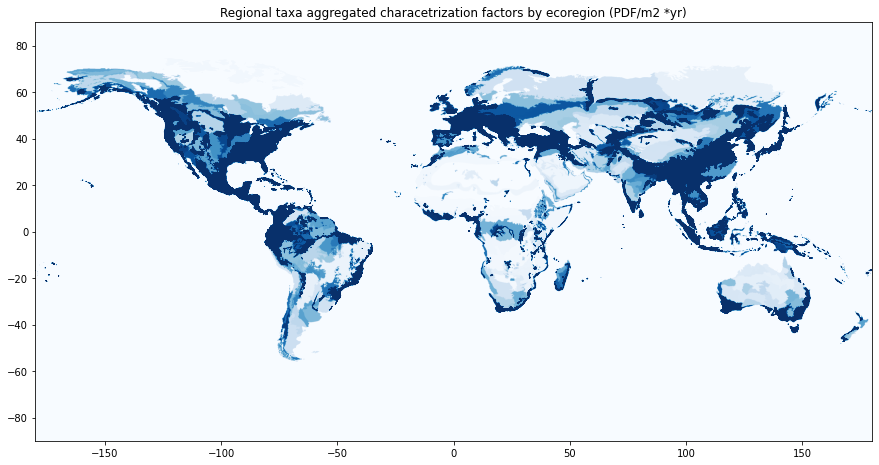

In [25]:
# check calculated risk map
with rio.open(
    "../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif"
) as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    # ax.set_ylim((-5,40))
    # ax.set_xlim((60,100))
    rio.plot.show(
        dat,
        vmin=2.8999999152285e-14,
        vmax=2.9376220100729e-12,
        cmap="Blues",
        ax=ax,
        transform=src.transform,
    )
    # test_gdf.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title("Regional taxa aggregated characetrization factors by ecoregion (PDF/m2 *yr)")

<a id='generate_risk'></a>
### 2. 5. Generate the biodiversity risk map

Now that we have the regional taxa aggregted characteriation factors rasterised for a global resolution we can calculate the biodiversity risk map due to land use chage. The formula would be:
    
    Biodiversity risk map (PDF / year ) =  area with tree cover loss and land use change (hectares) * taxa-aggregated characterization factors for Regional Potential Species Loss (PSL) (PDF / year * m2) *   (1/ 0.0001) (conversion units)


#### 4.1 Downsample the CF raster:

Before intersecting the two rasters we need to downsample the taxa aggregated characterization factors to the lowest resolution, in this case the same as the deforestation risk which is 0.000269494417976 (30m resolution). 

In [4]:
# clip taxa aggregated characetrisation factors to deforestation extent
!gdal_translate -projwin 100.024523992 2.91915145 103.814423992 -1.12192855 -of GTiff '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326.tif' '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_clipped.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [5]:
# downsample the clipped data
!gdalwarp -s_srs EPSG:4326 -tr 0.000269494417976 0.000269494417976 -r near -of GTiff '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_clipped.tif' '../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_30m.tif'

Creating output file that is 13915P x 14843L.
Processing ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_clipped.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_clipped.tif.
Copying nodata values from source ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_clipped.tif to destination ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_30m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [26]:
taxa_cf_4326 = "../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_30m.tif"
deforestation_4326 = (
    "../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018.tif"
)

In [27]:
## check that the rater size is the same for both layers
!gdalinfo $taxa_cf_4326

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/biodiversity_indicators/taxa_aggregated_characterization_factors_4326_30m.tif
Size is 13915, 14843
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (99.999999999984084,3.000000000004945)
Pixel Size = (0.000269494417976,-0.000269494417976)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0000000,   3.0000000) (100d 0' 0.00"E,  3d 0' 0.00"N)
Lower Left  ( 100

In [28]:
## check that the rater size is the same for both layers

!gdalinfo $deforestation_4326

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018.tif
Size is 14063, 14995
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (100.024523992019894,2.919151450478214)
Pixel Size = (0.000269494417976,-0.000269495165055)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0245240,   2.9191515) (100d 1'28.29"E,  2d55' 8.95"N)
Lower Left  ( 100.0245240,  -1.1219285

#### 4.2 Calculate the risk map

In [25]:
!gdal_translate -projwin 100.0000000 3.0000000 103.7500148 -1.0001056 -of GTiff $deforestation_4326 '../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018_new_extent.tif'

Input file size is 14063, 14995
Warning 1: Computed -srcwin -91 -300 13915 14843 falls partially outside raster extent. Going on however.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [26]:
# calculate biodiversity risk
!gdal_calc.py -A $taxa_cf_4326 -B '../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018_new_extent.tif' --outfile='../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif' --calc="A*B*(1/0.0001)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [31]:
!gdalinfo -stats -hist '../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif
Size is 13915, 14843
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (99.999999999984084,3.000000000004945)
Pixel Size = (0.000269494417976,-0.000269494417976)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0000000,   3.0000000) (100d 0' 0.00"E,  3d 0' 0.00"N)
Lower Left  ( 100.0000000,  -

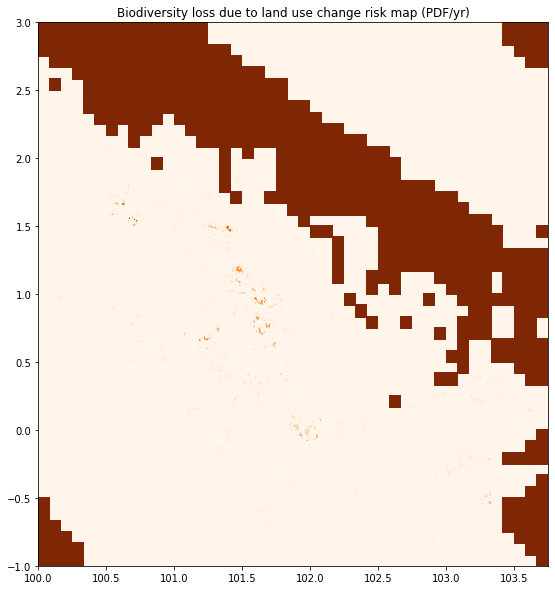

In [32]:
# generate a cog with the biodiversity risk map
# check calculated risk map
with rio.open(
    "../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif"
) as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    # ax.set_ylim((-5,40))
    # ax.set_xlim((60,100))
    rio.plot.show(
        dat,
        vmin=2.8999999152285e-14,
        vmax=1.1684577784499e-11,
        cmap="Oranges",
        ax=ax,
        transform=src.transform,
    )
    # test_gdf.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title("Biodiversity loss due to land use change risk map (PDF/yr)")

    # Dark red shows no data information
    # Beige shows 0 risk

<a id='impact_metric'></a>
## 3. Calculate biodiversity impact metric

Once we have the biodiversity risk due to land use change we can extimate the impact that can have a certain suplier in an area:

    Biodiversity loss due to land use change (PDF / year) =  biodiversity risk due to land use change (PDF/year) *  probability purchase area (unitless) 
    
Therefore, the first step would be to compute this probability purchase area for a certain location. 

<a id='probability_area'></a>
### 3. 1  Generate purchase area probability map

The formula (per pixel) is:

f' = V/At * f/y

V = Volume of commodity Purchased (const)
f = Area Fraction used to produce commodity (per pixel)
At = Total area used to produce ALL of the commodity (const)
where At = a*sum(f) i.e. integrated pixel area * f
a = pixel area
y = Commodity yield (per pixel)

#### 3.1.1 Get user data for a location

In [6]:
# import test data and filter by commodity - cotton (as the deforestation risk is for cotton) and indonesia (as the sample data es for indonesia)
gdf = gpd.read_file("../../datasets/processed/user_data/located_lg_data_polygon_v2.shp")
gdf.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [7]:
# lest assume that the risk map is for rubber - we will need to update this later on
gdf = gdf.loc[(gdf["Material"] == "Rubber") & (gdf["Country"] == "Indonesia")]
gdf

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
6,Rubber,None,2600,Indonesia,None,None,None,Origin country,Low,"POLYGON ((94.77171 5.79699, 94.79259 5.88108, ..."


In [45]:
yield_rubber = (
    "../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare.tif"
)
harvest_portion_rubber = (
    "../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction.tif"
)

In [54]:
# save test location
gdf.to_file(
    "../../datasets/raw/input_data_test/indonesia_test_shape.shp",
    driver="ESRI Shapefile",
)

#### 3.1.2 Generate raster with user volume

In [60]:
## generate a raster with same resolution as the yield and harvest portion
## with the user volume
!gdal_rasterize -l indonesia_test_shape -a Volume -tr 0.0833333333333286 0.0833333333333286 -a_nodata 0.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff '../../datasets/raw/input_data_test/indonesia_test_shape.shp' '../../datasets/raw/input_data_test/indonesia_raster_volume.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [61]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:4326 '../../datasets/raw/input_data_test/indonesia_raster_volume.tif'

In [62]:
## clip data to deforestation extent
# clip harvest area fraction to deforestation extent
!gdal_translate -projwin 100.024523992 2.91915145 103.814423992 -1.12192855 -of GTiff '../../datasets/raw/input_data_test/indonesia_raster_volume.tif' '../../datasets/raw/input_data_test/indonesia_raster_volume_4326_clipped.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [63]:
## downsample to deforestation resolution
!gdalwarp -s_srs EPSG:4326 -tr 0.000269494417976 0.000269494417976 -r near -of GTiff '../../datasets/raw/input_data_test/indonesia_raster_volume_4326_clipped.tif' '../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif'

Creating output file that is 13915P x 14843L.
Processing ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_clipped.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_clipped.tif.
Copying nodata values from source ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_clipped.tif to destination ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [39]:
# reproject raster volume from epsg4326 to espg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 30 30 -r near -of GTiff '../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif' '../../datasets/raw/input_data_test/indonesia_raster_volume_3857_30m.tif'

Creating output file that is 13915P x 14848L.
Processing ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif [1/1] : 0Using internal nodata values (e.g. 0) for image ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif.
Copying nodata values from source ../../datasets/raw/input_data_test/indonesia_raster_volume_4326_30m.tif to destination ../../datasets/raw/input_data_test/indonesia_raster_volume_3857_30m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


#### 3.1.3 Downsample harvest area fraction

In [57]:
# clip harvest area fraction to deforestation extent
!gdal_translate -projwin 100.024523992 2.91915145 103.814423992 -1.12192855 -of GTiff $harvest_portion_rubber '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_clipped.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [58]:
## downsample harvest area fraction -as it's area independent we can downsample the values into smaller pixel sizes
# downsample the clipped data
!gdalwarp -s_srs EPSG:4326 -tr 0.000269494417976 0.000269494417976 -r near -of GTiff '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_clipped.tif' '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_30m.tif'

Creating output file that is 13915P x 14843L.
Processing ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_clipped.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### 3.1.4 Compute total harvest area 

In [64]:
## reproject harvest area fraction
# reproject harvest area fraction
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 30 30 -r near -of GTiff '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_30m.tif' '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif'

Creating output file that is 13915P x 14848L.
Processing ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_4326_30m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [2]:
!gdalinfo '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
           

In [4]:
# generate raster with pixel area raster
# reclasifies the raster into 0 and pixel area being the pixel area just on thise locations with harvest area fraction
!gdal_calc.py -A '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif' --outfile='../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/pixel_area_rubber_raster_epsg3857.tif' --calc="(A > 0) * (30*30)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [5]:
## calculate the raster equal to pixel_are * area fraction to get the total area within a loctaion with summary statistics
!gdal_calc.py -A '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/pixel_area_rubber_raster_epsg3857.tif' -B '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif'  --outfile='../../datasets/raw/probability_map/area_total_rubber_raster_epsg3857.tif' --calc="(A * B)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [17]:
gdf = gdf.set_crs("EPSG:4326")
print(f"projection of user data is: {gdf.crs}")

projection of user data is: EPSG:4326


In [18]:
# reproject the gdf to epsg3857 for the zonal statistics
# reproject to epsg3857
gdf = gdf.to_crs("EPSG:3857")

In [20]:
gdf.to_file("../../datasets/processed/user_data/indonesia_test_3857.shp")

In [28]:
#clip gdf by raster extent
ogr2ogr -spat 11131949.0793 334111.1714 11549399.0793 -111328.8286 -clipsrc spat_extent '../../datasets/processed/user_data/indonesia_test_3857' '../../datasets/processed/user_data/indonesia_test_3857.shp' indonesia_test_3857

SyntaxError: invalid syntax (<ipython-input-28-995f772177cd>, line 2)

In [26]:
!ogr2ogr -spat 11131949.0793 334111.1714 11549399.0793 -111328.8286 -clipsrc spat_extent ../../datasets/processed/user_data/indonesia_test_3857_clip.gpkg ../../datasets/processed/user_data/indonesia_test_3857.shp indonesia_test_3857 -f "GPKG"

In [31]:
gdf = gpd.read_file("../../datasets/raw/input_data_test/indonesia_test_shape_clip.shp")
gdf

,fid,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,1.0,Rubber,None,2600.0,Indonesia,None,None,None,Origin country,Low,"POLYGON ((11206146.856 334111.171, 11237288.10..."


In [32]:
# zonal stats in india to get the sum of all fraction harvest area
total_harves_area_rubber = (
    "../../datasets/raw/probability_map/area_total_rubber_raster_epsg3857.tif"
)
start_time = time.time()
zs_indonesia_test = zonal_stats(gdf, total_harves_area_rubber, stats="sum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.0787129402160645 seconds ---


In [33]:
print(" The total rubber harvest area in indonessua is :", {zs_indonesia_test[0]["sum"]}, "m2")

 The total rubber harvest area in indonessua is : {1871586176.0} m2


In [34]:
## ad field to gdf
gdf["Total_af"] = zs_indonesia_test[0]["sum"]
gdf

,fid,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry,Total_af
0,1.0,Rubber,None,2600.0,Indonesia,None,None,None,Origin country,Low,"POLYGON ((11206146.856 334111.171, 11237288.10...",1.871586e+09


In [35]:
gdf.to_file("../../datasets/processed/user_data/indonesia_test_3857.shp")

In [37]:
## generate a raster with same extent as the other ones with this total area fraction value
!gdal_rasterize -l indonesia_test_3857 -a Total_af -tr 30 30 -a_nodata 0.0 -ot Float32 -of GTiff '../../datasets/processed/user_data/indonesia_test_3857.shp' '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [38]:
## add projection - same as the other ones for the calculations
!gdal_edit.py -a_srs EPSG:3857 '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af.tif'

#### 3.1.5 Downsample yield


In [40]:
# clip harvest area fraction to deforestation extent
!gdal_translate -projwin 100.024523992 2.91915145 103.814423992 -1.12192855 -of GTiff '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare.tif' '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_clipped.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [42]:
## downsample harvest area fraction -as it's area independent we can downsample the values into smaller pixel sizes
# downsample the clipped data
!gdalwarp -s_srs EPSG:4326 -tr 0.000269494417976 0.000269494417976 -r near -of GTiff '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_clipped.tif' '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_30m.tif'

Creating output file that is 13915P x 14843L.
Processing ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_clipped.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [43]:
# reproject yield from epsg4326 to epsg3857
# reproject raster volume from epsg4326 to espg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 30 30 -r near -of GTiff '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_30m.tif' '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_3857_30m.tif'

Creating output file that is 13915P x 14848L.
Processing ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_4326_30m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### 3.1.6 Calculate probability map
T
he formula would be:

f' = (V * Af) / (AT * Yield)

In [45]:
!gdalinfo '../../datasets/raw/input_data_test/indonesia_raster_volume_3857_30m.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/input_data_test/indonesia_raster_volume_3857_30m.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        P

In [46]:
!gdalinfo '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
           

In [47]:
!gdalinfo '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/probability_map/indonesia_rubber_raster_total_af.tif
Size is 13916, 14849
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        P

In [51]:
# fix extent od total area fraction raster
!gdal_translate -projwin 11131949.079  334111.171 11549399.079 -111328.829 -of GTiff '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af.tif' '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af_new_extent.tif'

Input file size is 13916, 14849
0...10...20...30...40...50...60...70...80...90...100 - done.


In [52]:
!gdalinfo '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af_new_extent.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/probability_map/indonesia_rubber_raster_total_af_new_extent.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]]

In [53]:
# generate raster with pixel area raster
# reclasifies the raster into 0 and pixel area being the pixel area just on thise locations with harvest area fraction
!gdal_calc.py -A '../../datasets/raw/input_data_test/indonesia_raster_volume_3857_30m.tif' -B '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_HarvestedAreaFraction_3857_30m.tif' -C '../../datasets/raw/probability_map/indonesia_rubber_raster_total_af_new_extent.tif' -D '../../datasets/raw/crop_data/rubber_HarvAreaYield_Geotiff/rubber_YieldPerHectare_3857_30m.tif' --outfile='../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif' --calc="(A*B)/(C*D)"

<string>:1: RuntimeWarning: invalid value encountered in true_divide
<string>:1: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [55]:
!gdalinfo -stats -hist '../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["E

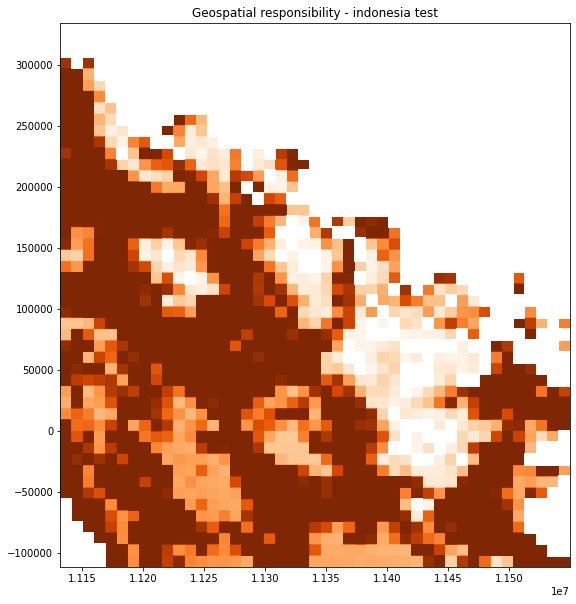

In [56]:
with rio.open(
    "../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif"
) as src:
    image_array = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.set_ylim((-111328.8286, 334111.1714))
    ax.set_xlim((1.113195e07, 1.154940e07))
    rio.plot.show(
        image_array,
        vmin=7.6509659718837e-11,
        vmax=3.2353862778438e-08,
        cmap="Oranges",
        ax=ax,
        transform=src.transform,
    )
    ax.set_title("Geospatial responsibility - indonesia test")

<a id='biodiversity_metric'></a>
### 3.2 Calculate biodiversity loss due to land use change in test location

    Biodiversity loss due to land use change (PDF / year) =  biodiversity risk due to land use change (PDF/year) *  probability purchase area (unitless) 
    

In [59]:
!gdalinfo '../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif' 

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif
       ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif.aux.xml
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popu

In [64]:
!gdalinfo '../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif
       ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif.aux.xml
Size is 13915, 14843
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (99.999999999984084,3.000000000004945)
Pixel Size = (0.000269494417976,-0.000269494417976)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordina

In [65]:
# reproject biodiversity risk map from epsg4326 to epsg3857
# reproject raster volume from epsg4326 to espg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 30 30 -r near -of GTiff '../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif' '../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg3857_PDF.tif'

Creating output file that is 13915P x 14848L.
Processing ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif.
Copying nodata values from source ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg4326_PDF.tif to destination ../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg3857_PDF.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [66]:
!gdal_calc.py -A '../../datasets/processed/biodiversity_indicators/biodiversity_risk_cotton_epsg3857_PDF.tif' -B '../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif'  --outfile='../../datasets/processed/biodiversity_indicators/biodiversity_loss_dueTo_landusechange_3857_30m.tif' --calc="(A*B)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [68]:
!gdalinfo -stats -hist '../../datasets/processed/biodiversity_indicators/biodiversity_loss_dueTo_landusechange_3857_30m.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/biodiversity_indicators/biodiversity_loss_dueTo_landusechange_3857_30m.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
           

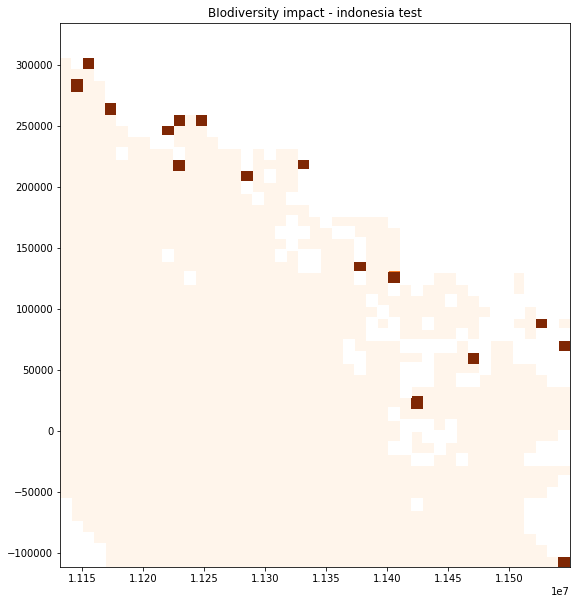

In [70]:
with rio.open(
    "../../datasets/processed/biodiversity_indicators/biodiversity_loss_dueTo_landusechange_3857_30m.tif"
) as src:
    image_array = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.set_ylim((-111328.8286, 334111.1714))
    ax.set_xlim((1.113195e07, 1.154940e07))
    rio.plot.show(
        image_array, vmin=0, vmax=3.6318996466515e28, cmap="Oranges", ax=ax, transform=src.transform
    )
    ax.set_title("BIodiversity impact - indonesia test")

<a id='final_notes'></a>
## 4. Final notes

- we dont need to downsample every single part of the probability area. We can just compute the probability area with the 10km resolution and donwsample teh final result.